## Model metrics

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from metrics_utils import *

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [4]:
LOG_PATH = "lightning_logs"
METRICS_PATH = "../Metrics"

## Generate cleaned up csv files for each run

In [3]:
model_ids = ['g_lenet_cut_dataset_repeat',
             'lenet_cut_dataset_repeat',
             'resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
             'jiaresnet50_cut_dataset_repeat',
             'G_ResNet18_cut_dataset_repeat']

def save_run(model_ids,max_runs):
    for model in model_ids:
        for run in range(max_runs):
            print(f"{model}, run {run}")
            try:
                save_metrics_from_logger(model,LOG_PATH,METRICS_PATH,version=run)
            except:
                print(f"Error with {model}, run {run}")

#save_run(model_ids,5) #No longer needed as newer framework does this automatically

## Create graphs for each run

In [17]:
def generate_graphs_run(model_ids,max_runs):
    for model in model_ids:
        for run in range(max_runs):
            #print(f"{model}, run {run}")
            try:
                plot_train_metrics(model,METRICS_PATH,version=run,show=False)
            except:
                print(f"Error with {model}, run {run}")
#generate_graphs_run(model_ids,5) 

## Get best loss epoch for each run

In [39]:
def get_train_results_runs(model_ids,max_runs):
    repeat_metrics = pd.DataFrame(columns=["Loss","Accuracy","ECE","C Viol"],index=model_ids)
    repeat_metrics.columns.name="Model"
    for model in model_ids:
        best_losses = []
        best_accs = []
        best_eces = []
        best_chiralities = []
        for run in range(max_runs):
            try:
                metrics = get_metrics_from_csv(model,METRICS_PATH,version=run)
                #best_loss_epoch = 59 
                best_loss_epoch = metrics['val_loss'].argmin()
                best_losses.append(metrics['val_loss'][best_loss_epoch])
                best_accs.append(metrics['val_acc'][best_loss_epoch])
                best_eces.append(metrics['val_calibration_error'][best_loss_epoch])
                best_chiralities.append((metrics['val_chirality_violation'][best_loss_epoch]))
            except:
                print(f"Error with {model}, run {run}")

        # if model == 'LeNet_cut_dataset_repeat':
        #     print(best_chiralities)
        repeat_metrics.loc[model] = {"Loss": f"{np.average(best_losses):.4f} ± {np.std(best_losses):.4f}",
                                        "Accuracy": f"{np.average(best_accs):.2%} ± {np.std(best_accs):.2%}",
                                        "ECE": f"{np.average(best_eces):.4f} ± {np.std(best_eces):.4f}",
                                        "C Viol": f"{np.average(best_chiralities):.4f} ± {np.std(best_chiralities):.4f}"}
    #print(tabulate(repeat_metrics,headers='keys',tablefmt='github'))
    return repeat_metrics

repeat_metrics = get_train_results_runs(model_ids,5)
repeat_metrics.head(6)

Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.7821 ± 0.0351,77.54% ± 2.58%,0.1587 ± 0.0089,0.4174 ± 0.2577
lenet_cut_dataset_repeat,0.8562 ± 0.0341,70.61% ± 3.42%,0.1421 ± 0.0146,nan ± nan
resnet18_cut_dataset_repeat,0.5290 ± 0.0003,98.16% ± 0.12%,0.2273 ± 0.0023,0.4963 ± 0.1710
resnet50_cut_dataset_repeat,0.5309 ± 0.0002,97.40% ± 0.13%,0.2195 ± 0.0031,0.7647 ± 0.3068
jiaresnet50_cut_dataset_repeat,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
G_ResNet18_cut_dataset_repeat,0.5346 ± 0.0024,97.79% ± 0.25%,0.2235 ± 0.0041,0.5458 ± 0.1820


In [40]:
def get_test_results_runs(model_ids,max_runs):
    repeat_metrics = pd.DataFrame(columns=["Loss","Accuracy","ECE","C Viol"],index=model_ids)
    repeat_metrics.columns.name="Model"
    for model in model_ids:
        best_losses = []
        best_accs = []
        best_eces = []
        best_chiralities = []
        for run in range(max_runs):
            try:
                metrics = get_metrics_from_csv(model,METRICS_PATH,version=run,mode='test')
                best_losses.append(metrics['test_loss'])
                best_accs.append(metrics['test_acc'])
                best_eces.append(metrics['test_calibration_error'])
                best_chiralities.append((metrics['test_chirality_violation']))
            except:
                print(f"Error with {model}, run {run}")

        # if model == 'LeNet_cut_dataset_repeat':
        #     print(best_chiralities)
        nans_removed = np.count_nonzero(np.isnan(np.concatenate((best_losses, best_accs, best_eces, best_chiralities))))
        if nans_removed > 0:
            print(f"{model}: Removed {nans_removed} NaNs")
        best_losses = np.array(best_losses)[~np.isnan(best_losses)]
        best_accs = np.array(best_accs)[~np.isnan(best_accs)]
        best_eces = np.array(best_eces)[~np.isnan(best_eces)]
        best_chiralities = np.array(best_chiralities)[~np.isnan(best_chiralities)]
        
        
        repeat_metrics.loc[model] = {"Loss": f"{np.average(best_losses):.4f} ± {np.std(best_losses):.4f}",
                                        "Accuracy": f"{np.average(best_accs):.2%} ± {np.std(best_accs):.2%}",
                                        "ECE": f"{np.average(best_eces):.4f} ± {np.std(best_eces):.4f}",
                                        "C Viol": f"{np.average(best_chiralities):.4f} ± {np.std(best_chiralities):.4f}"}
    #print(tabulate(repeat_metrics,headers='keys',tablefmt='github'))
    return repeat_metrics

repeat_metrics = get_test_results_runs(model_ids,5)
repeat_metrics.head(6)

g_lenet_cut_dataset_repeat: Removed 4 NaNs
lenet_cut_dataset_repeat: Removed 5 NaNs
resnet18_cut_dataset_repeat: Removed 1 NaNs
resnet50_cut_dataset_repeat: Removed 1 NaNs


/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.5098 ± 0.0087,89.53% ± 0.28%,0.1545 ± 0.0085,0.1405 ± 0.0000
lenet_cut_dataset_repeat,0.5192 ± 0.0095,89.60% ± 0.60%,0.1797 ± 0.0121,nan ± nan
resnet18_cut_dataset_repeat,0.4514 ± 0.0075,92.18% ± 0.29%,0.1109 ± 0.0040,0.9351 ± 0.3880
resnet50_cut_dataset_repeat,0.4579 ± 0.0077,92.32% ± 0.37%,0.1201 ± 0.0060,1.3171 ± 0.4113
jiaresnet50_cut_dataset_repeat,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
G_ResNet18_cut_dataset_repeat,0.4723 ± 0.0548,91.09% ± 1.64%,0.1063 ± 0.0089,0.3742 ± 0.5673


In [26]:
#          blue      orange     reddish purple  sky blue   bluish green  amber        vermillion  
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",   "#F5C710",  "#D55E00"  ]
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",  "#D55E00"  ]

def plot_combined_metrics(model_ids,metric,metric_label):
    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(metric_label)

    for i,model in enumerate(model_ids):
        metrics = get_metrics_from_csv(model,METRICS_PATH,version=2,mode='train')
        # train_loss = metrics['train_loss_epoch']
        # train_acc = metrics['train_acc_epoch']
        # val_loss = metrics['val_loss']
        m = metrics[metric]
        epoch = metrics.index
        label = model.removesuffix('_cut_dataset_repeat')

        ax1.plot(epoch,m,linestyle='-',c=colours[i],label=label,linewidth=1.7)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid()
    plt.show()

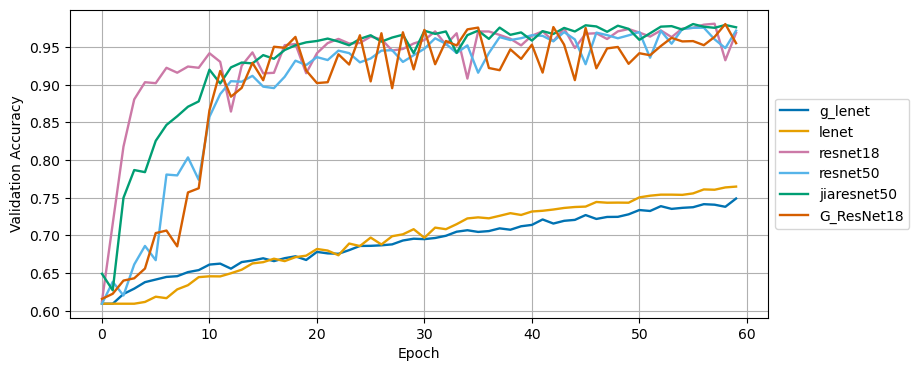

In [27]:
plot_combined_metrics(model_ids,'val_acc','Validation Accuracy')

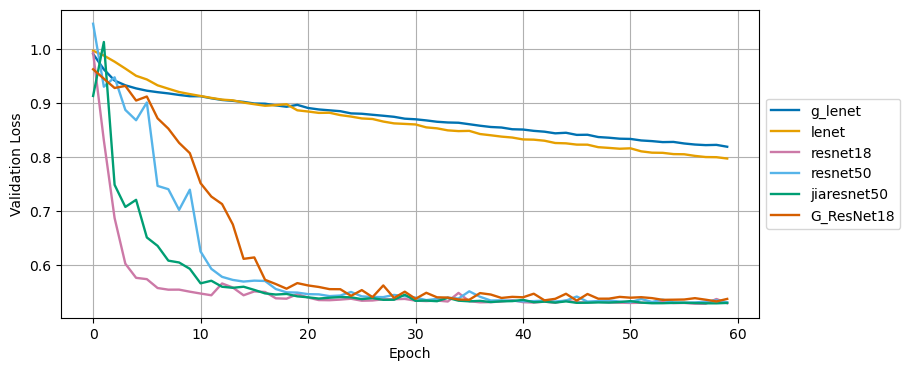

In [28]:
plot_combined_metrics(model_ids,'val_loss','Validation Loss')

## Prediction Metrics

In [23]:
def chirality_violation(num_acw,num_cw):
        return (num_cw-num_acw)/np.sqrt(num_cw+num_acw)

def summarise_predictions(model_id,dataset_name,version=0):
    predictions = pd.read_csv(f"{METRICS_PATH}/{model_id}/version_{version}/{dataset_name}_predictions.csv",header=None, on_bad_lines = 'skip').astype('float')
    predictions = predictions.idxmax(axis=1)
    num_acw = predictions[predictions==0].shape[0]
    num_cw = predictions[predictions==1].shape[0]
    num_other = predictions[predictions==2].shape[0]
    num = predictions.shape[0]
    print(f"Total: {num}. ACW: {num_acw} ({num_acw/num:.1%}). CW: {num_cw} ({num_cw/num:.1%}). Other: {num_other} ({num_other/num:.1%})")
    print(f"Chirality Violation: {chirality_violation(num_acw,num_cw):3.2f} sigma")

summarise_predictions("resnet18_cut_dataset","full_desi_dataset")
summarise_predictions("g_resnet18_cut_dataset","full_desi_dataset")
summarise_predictions("resnet50_cut_dataset","full_desi_dataset")
summarise_predictions("jiaresnet50_cut_dataset","full_desi_dataset")

Total: 1000000. ACW: 12750 (1.3%). CW: 15642 (1.6%). Other: 971608 (97.2%)
Chirality Violation: 17.16 sigma
Total: 1000000. ACW: 18117 (1.8%). CW: 21674 (2.2%). Other: 960209 (96.0%)
Chirality Violation: 17.83 sigma
Total: 1000000. ACW: 13772 (1.4%). CW: 17187 (1.7%). Other: 969041 (96.9%)
Chirality Violation: 19.41 sigma
Total: 1000000. ACW: 12324 (1.2%). CW: 12575 (1.3%). Other: 975101 (97.5%)
Chirality Violation: 1.59 sigma
